In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [4]:
config = Dataset_load.load_config()
colors = config['colors']['one']

## Read dataset

In [5]:

scaled_amplitude = Parameter('amplitude', 
                             value = 1e-12)
dataset_asimov  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                            parameters = Parameters([scaled_amplitude]))
print(dataset_asimov)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz
MapDataset
----------

  Name                            : 1nZ1RO5N 

  Total counts                    : 414547 
  Total background counts         : 413238.21
  Total excess counts             : 1309.11

  Predicted counts                : 414547.31
  Predicted background counts     : 413238.21
  Predicted excess counts         : 1309.11

  Exposure min                    : 1.57e-25 m2 s
  Exposure max                    : 1.27e+11 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 942469 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 850189.06

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : aEaZD8Bs
    Datasets names            : None
    Spectral model type       : PowerLawSpe

(<WCSAxes: >, <Axes: xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

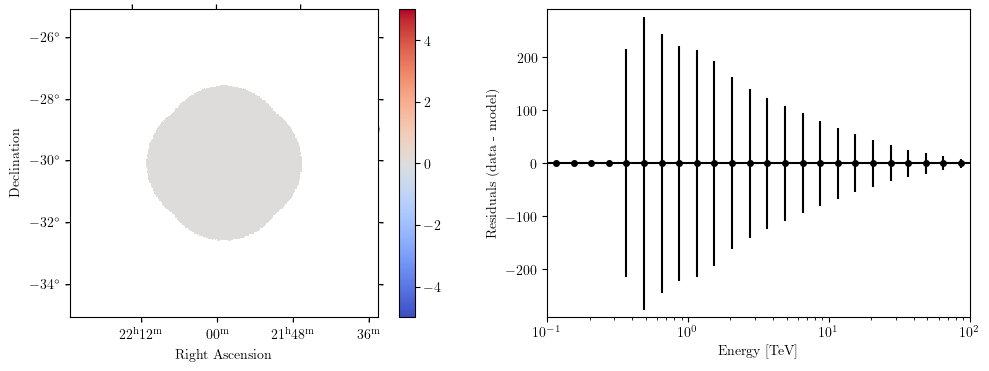

In [6]:
dataset_asimov.plot_residuals()

## Asimov Cases

In [7]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value


shift_as = 0.1
tilt_as = 0.02
bias_as, resolution_as = 0.1,0.1
bkg_norm_as, bkg_tilt_as = 0.1, 0.02


In [8]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0., 
                        tilt = 0.,
                        bias = 0.,
                        resolution = 0.,
                        bkg_norm = 0., 
                        bkg_tilt = 0., 
                        rnd = False,
                        e_reco_creation=100)
dataset_cor_N = sys_d_cor.create_dataset_N(100)
dataset_cor = sys_d_cor.create_dataset()




zero = 1e-24
    
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((6, 6))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/bkg_norm_as ** 2, 1/ bkg_tilt_as**2 ,1/bias_as**2, 1/resolution_as**2, 1/shift_as**2, 1/tilt_as**2, ])

dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.background_model.parameters['tilt_nuisance'].frozen = False
dataset_cor_N.irf_model.parameters['tilt_nuisance'].frozen = False



In [9]:
print(dataset_cor.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : ELsEszxn-bkg
  Datasets names            : ['ELsEszxn']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference    

In [10]:
print(dataset_cor_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                          :      0.000   +/-    0.00             
    ref

In [11]:
print(dataset_cor_N.background_model.spectral_model)

CompoundNormSpectralModel
    Component 1 : PowerLawNormSpectralModel

  type      name     value    unit   error   min max frozen is_norm is_penalised link
-------- --------- ---------- ---- --------- --- --- ------ ------- ------------ ----
spectral      norm 1.0000e+00      0.000e+00 nan nan  False    True        False     
spectral      tilt 0.0000e+00      0.000e+00 nan nan  False   False        False     
spectral reference 1.0000e+00  TeV 0.000e+00 nan nan   True   False        False     
    Component 2 : PowerLawNormPenSpectralModel

  type        name       value    unit   error   min max frozen is_norm is_penalised link
-------- ------------- ---------- ---- --------- --- --- ------ ------- ------------ ----
spectral norm_nuisance 0.0000e+00      0.000e+00 nan nan  False    True         True     
spectral tilt_nuisance 0.0000e+00      0.000e+00 nan nan  False   False         True     
spectral     reference 1.0000e+00  TeV 0.000e+00 nan nan   True   False        False     
 

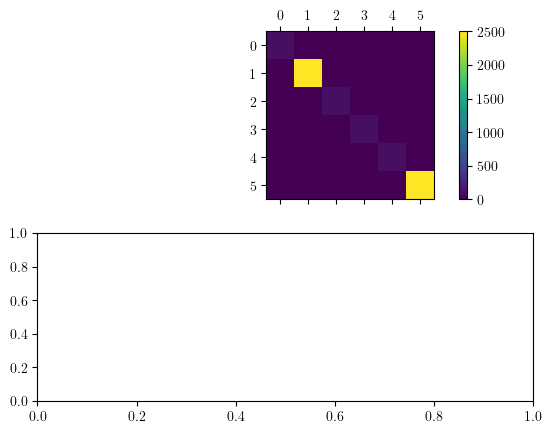

In [12]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);


corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.502e+05                  │              Nfcn = 94               │
│ EDM = 2.52e-05 (Goal: 0.0002)    │           time = 16.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

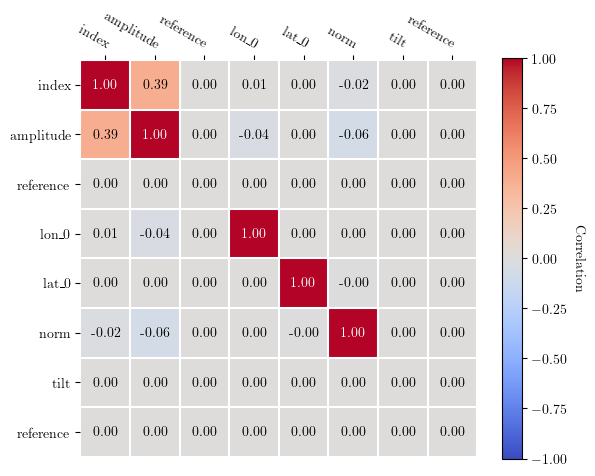

In [13]:
%%time
fitting = 1

if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    #minuit_opts = {"tol": 0.001, "strategy": 2}
    #fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_cor)
    dataset_cor.models.covariance = fit_cor.covariance(dataset_cor).matrix
    dataset_cor.models.covariance.plot_correlation()
    print(fit_cor.minuit)
    
    path = f'data/2_model.yml'
    dataset_cor.models.write(path,overwrite=True)
    
else:
    print("read")
    path = f'data/2_model.yml'
    dataset_cor = Dataset_load.load_dataset(dataset_cor, path)        
         
    



In [14]:
print(dataset_cor.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.05             
    amplitude                     :   1.00e-12   +/- 5.1e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : ELsEszxn-bkg
  Datasets names            : ['ELsEszxn']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference    

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.502e+05                  │              Nfcn = 664              │
│ EDM = 0.00171 (Goal: 0.0002)     │           time = 937.8 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬────

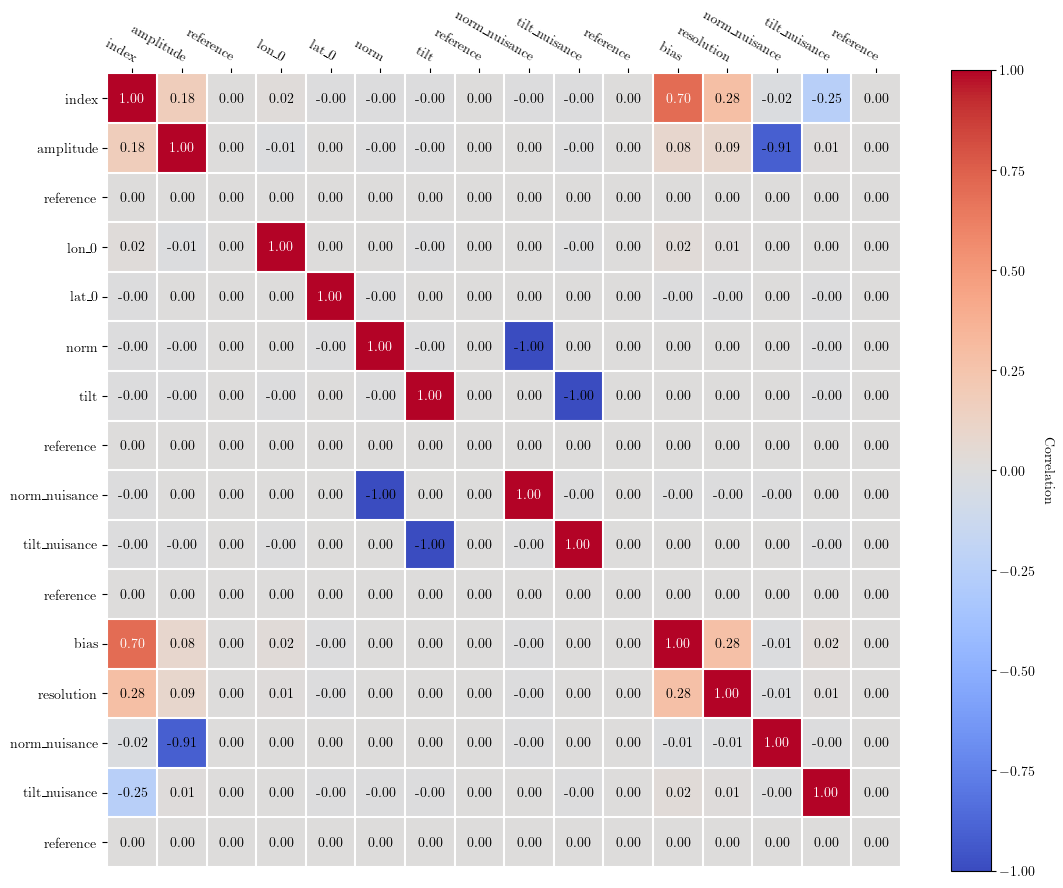

In [15]:
%%time
fitting = 1
#13min 25s



if fitting:

    print("corr")
    fit_cor = Fit(store_trace=True)
    #minuit_opts = {"tol": 0.001, "strategy": 2}
    #fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_cor_N)
    dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
    dataset_cor_N.models.covariance.plot_correlation()
    print(fit_cor.minuit)
    
    path = f'data/2_model_nui.yml'
    dataset_cor_N.models.write(path,overwrite=True, )
    
else:
    print("read")
    path = f'data/2_model_nui.yml'
    dataset_cor_N = Dataset_load.load_dataset_N(dataset_cor_N, path, bkg_sys = True)        
         
    



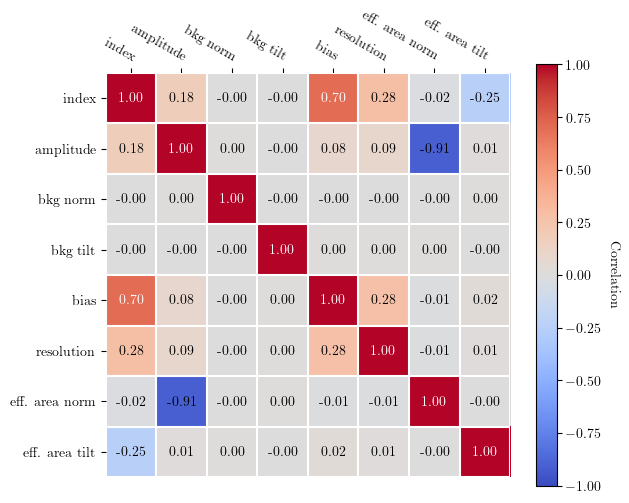

In [16]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm_nuisance' , 
            'tilt_nuisance']

dataset_cor_N.models.read_covariance("data", f"2_model_nui_covariance.dat", format="ascii.fixed_width")
parameters = Parameters([_ for _ in dataset_cor_N.models.parameters if _.name in par_names])
cov_par = dataset_cor_N.models.covariance.get_subcovariance(parameters)
names =  ['index', 'amplitude', 
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']

ax = cov_par.plot_correlation(names = names)
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_covmatrix_combination.png")

In [17]:
print(dataset_cor_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : aEaZD8Bs
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.302   +/-    0.07             
    amplitude                     :   1.00e-12   +/- 1.2e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : CompoundNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.10             
    tilt                          :      0.000   +/-    0.02             
    ref

In [18]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m.parameters[p[0]],
                 m.parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])
            except:
                pass

    plt.tight_layout()

labels = ['simulated', 'recovered with nuisance', 'recovered']
fmts = ['o','x', '*']
markersize = [6,10, 11]

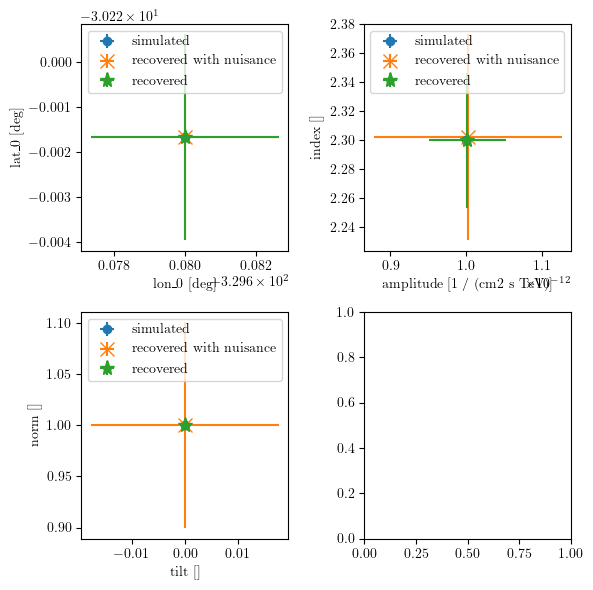

In [19]:
models_list = [dataset_asimov.models, dataset_cor_N.models,dataset_cor.models,  ]

pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'), ('tilt', 'norm')]
plot_source_par(0, pars)


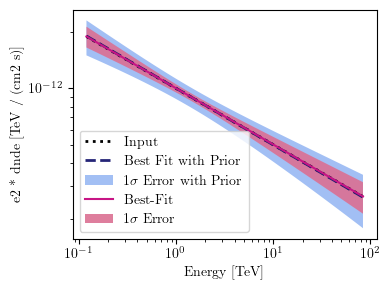

In [20]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,1,figsize = (4,3))
energy_power=2
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power, ax =axs, 
                                label = "Input", color = 'black', linewidth = energy_power, linestyle="dotted")
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,color = colors[1],
                                                         label="Best Fit with Prior",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[3],
                                                         label="$1\sigma$ Error with Prior",
                                                        alpha = 0.6)

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "Best-Fit", color = colors[0])

dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[2],
                                                          alpha = 0.9,
                                                          label= "$1\sigma$ Error"
                                                         )

axs.legend() 
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.png", dpi = 300)

In [21]:
par_name = "amplitude"
print(par_name)
par_input  = dataset_asimov.models.parameters[par_name]

par  = dataset_cor_N.models.parameters[par_name]
print(f"Nusiacnce {par_input.value:.5}: {par.value:.5} \pm {par.error:.4}")
par  = dataset_cor.models.parameters[par_name]
print(f"Standard  {par_input.value:.5}: {par.value:.5} \pm {par.error:.4}")



amplitude
Nusiacnce 1e-12: 1.0016e-12 \pm 1.239e-13
Standard  1e-12: 1.0013e-12 \pm 5.065e-14


In [22]:
par_name = "index"
print(par_name)
par_input  = dataset_asimov.models.parameters[par_name]

par  = dataset_cor_N.models.parameters[par_name]
print(f"Nusiacnce {par_input.value:.5}: {par.value:.4} \pm {par.error:.4}")
par  = dataset_cor.models.parameters[par_name]
print(f"Standard  {par_input.value:.5}: {par.value:.4} \pm {par.error:.4}")



index
Nusiacnce 2.3: 2.302 \pm 0.07101
Standard  2.3: 2.3 \pm 0.0464


In [23]:
par_name = "norm"
print(par_name)
par_input  = dataset_asimov.models.parameters[par_name]

par  = dataset_cor_N.models.parameters[par_name]
print(f"Nusiacnce {par_input.value:.5}: {par.value:.4} \pm {par.error:.4}")
par  = dataset_cor.models.parameters[par_name]
print(f"Standard  {par_input.value:.5}: {par.value:.4} \pm {par.error:.4}")



norm
Nusiacnce 1.0: 1.0 \pm 0.1006
Standard  1.0: 1.0 \pm 0.00156
